# Transfer Learning Approach

Transfer Learning is the first approach to solve problem of aircraft classification. There are 4 applications tested:

    - Xception,
    - VGG16,
    - ResNet50,
    - InceptionV3

## Prerequisites & Initial Data:

In [1]:
from keras.applications import Xception, VGG16, ResNet50,InceptionV3,InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import SGD

import tensorflow.keras.applications.inception_v3
import tensorflow.keras.applications.xception
import tensorflow.keras.applications.resnet
import tensorflow.keras.applications.vgg16
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
applications = ['Xception', 'VGG16', 'ResNet50','InceptionV3']
sizes = {'Xception': (299, 299, 3),
        'VGG16' : (224, 224, 3),
        'ResNet50' : (224, 224, 3),
        'InceptionV3' : (299, 299, 3)}

Due to the fact that the same procedure has to be done for each application, <b>model_creation</b> function, <b>prepare_dataset</b> function and <b>train_model</b> function is created. See docstrings for details.

In [3]:
def model_creation(name_str, sizes = sizes):
    """ Function to create tensorflow model which consists of base model(one of Keras Transfer Learning Applications)
    and top model for classification. Whole base model is frozen (not trained).
    
    Parameters:
    name_str (string): name of base model used, must be consistent with names from https://keras.io/api/applications/
        Note: name_str is case sensitive
    sizes (dict): dictionary of input shapes defined for specific application.
    Returns:
    model: tensorflow model which consists of base model(one of Keras Transfer Learning Applications)
    and top model for classification. Whole base model is frozen (not trained)
    """
    base_model = globals()[name_str](weights = 'imagenet', include_top=False, input_shape = sizes[name_str])
    
    for layer in base_model.layers:
        layer.trainable = False

    top_model = Sequential()
    top_model.add(Flatten(input_shape = base_model.output_shape[1:]))
    top_model.add(Dense(200, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(100, activation='softmax'))
    
   
    model = Sequential()
    model.add(base_model)
    model.add(top_model)
    
    return model

In [4]:
def prepare_dataset(model):
    """ Function to create train, test and validation datasets with image augumentation and proper preprocessing
    for keras applications.
    
    Parameters:
    model: name of base model used, must be consistent with names from https://keras.io/api/applications/
        Note: model is case sensitive
    Returns:
    train, test, validation : datasets with image augumentation and proper preprocessing for keras applications.
    """
    if model == 'Xception':
        preprocess_input = tensorflow.keras.applications.xception.preprocess_input
    elif model == 'VGG16':
        preprocess_input = tensorflow.keras.applications.vgg16.preprocess_input
    elif model == 'ResNet50':
        preprocess_input = tensorflow.keras.applications.resnet.preprocess_input
    elif model == 'InceptionV3':
        preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input
        
    img_gen = ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 rotation_range=45,
                                 horizontal_flip=True,
                                 preprocessing_function=preprocess_input)
    
    train = img_gen.flow_from_directory('data/variant/train',
                                         target_size = sizes[model][0:2])
    test = img_gen.flow_from_directory('data/variant/test',
                                         target_size = sizes[model][0:2])
    val = img_gen.flow_from_directory('data/variant/val',
                                         target_size = sizes[model][0:2])
    return train, test, val
    

40 Epochs used for preliminary rating of transfer learning models.

In [5]:
def train_model(model, sizes, batch_size, list_of_models):
    """ Function to create train, test and validation datasets with image augumentation and proper preprocessing
    for keras applications.
    
    Parameters:
    model: name of base model used, must be consistent with names from https://keras.io/api/applications/
        Note: model is case sensitive
    sizes (dict): dictionary of input shapes defined for specific application.
    batch_size (int): Model batch size
    list_of_models (list): empty list to store names of models
    """
    
    model_name = 'model_' + model
    globals()[model_name] = model_creation(model, sizes)
    list_of_models.append(model_name)
        
    train_name = 'train_' + model
    test_name = 'test_' + model
    val_name = 'val_' + model
    
    globals()[train_name], globals()[test_name], globals()[val_name] = prepare_dataset(model)
    
    history_name = 'history_' + model
    
    checkpoint_path = 'checkpoint/' + model_name + '-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True)
    early_stopping = EarlyStopping(patience=15,monitor="val_loss") 
    globals()[history_name] = History()
    globals()[model_name].compile(loss="categorical_crossentropy",optimizer= 'SGD', metrics=["accuracy"])   
    globals()[model_name].fit(globals()[train_name], epochs = 40, batch_size = batch_size,
                     validation_data = globals()[val_name], callbacks=[early_stopping, checkpoint, globals()[history_name]])
    
    evaluation_name = 'evaluation_' + model
    
    globals()[evaluation_name] =  globals()[model_name].evaluate(globals()[val_name])
    
    
    

Training of each model

In [6]:
list_of_models = []
for app in applications:
    train_model(app,sizes,32,list_of_models)

Found 3315 images belonging to 100 classes.
Found 3307 images belonging to 100 classes.
Found 3306 images belonging to 100 classes.
Epoch 1/40
104/104 [==============================] - 203s 2s/step - loss: 4.8290 - accuracy: 0.0078 - val_loss: 4.6052 - val_accuracy: 0.0100

Epoch 00001: val_loss improved from inf to 4.60517, saving model to checkpoint/model_Xception-ep001-loss4.663-val_loss4.605.h5
Epoch 2/40
104/104 [==============================] - 186s 2s/step - loss: 4.6054 - accuracy: 0.0077 - val_loss: 4.6052 - val_accuracy: 0.0100

Epoch 00002: val_loss improved from 4.60517 to 4.60517, saving model to checkpoint/model_Xception-ep002-loss4.605-val_loss4.605.h5
Epoch 3/40
104/104 [==============================] - 189s 2s/step - loss: 4.6054 - accuracy: 0.0101 - val_loss: 4.6052 - val_accuracy: 0.0100

Epoch 00003: val_loss improved from 4.60517 to 4.60517, saving model to checkpoint/model_Xception-ep003-loss4.606-val_loss4.605.h5
Epoch 4/40
104/104 [===========================

Epoch 1/40
104/104 [==============================] - 104s 969ms/step - loss: 5.5644 - accuracy: 0.0051 - val_loss: 4.6052 - val_accuracy: 0.0100

Epoch 00001: val_loss improved from inf to 4.60517, saving model to checkpoint/model_ResNet50-ep001-loss4.866-val_loss4.605.h5
Epoch 2/40
104/104 [==============================] - 98s 946ms/step - loss: 4.6064 - accuracy: 0.0076 - val_loss: 4.6052 - val_accuracy: 0.0100

Epoch 00002: val_loss improved from 4.60517 to 4.60517, saving model to checkpoint/model_ResNet50-ep002-loss4.607-val_loss4.605.h5
Epoch 3/40
104/104 [==============================] - 98s 948ms/step - loss: 4.6052 - accuracy: 0.0067 - val_loss: 4.6052 - val_accuracy: 0.0100

Epoch 00003: val_loss did not improve from 4.60517
Epoch 4/40
104/104 [==============================] - 98s 942ms/step - loss: 4.6052 - accuracy: 0.0064 - val_loss: 4.6052 - val_accuracy: 0.0100

Epoch 00004: val_loss did not improve from 4.60517
Epoch 5/40
104/104 [==============================] - 9

104/104 [==============================] - 178s 2s/step - loss: 4.6052 - accuracy: 0.0102 - val_loss: 4.6052 - val_accuracy: 0.0100

Epoch 00023: val_loss did not improve from 4.60515
104/104 [==============================] - 89s 850ms/step - loss: 4.6052 - accuracy: 0.0100


Learning process curves

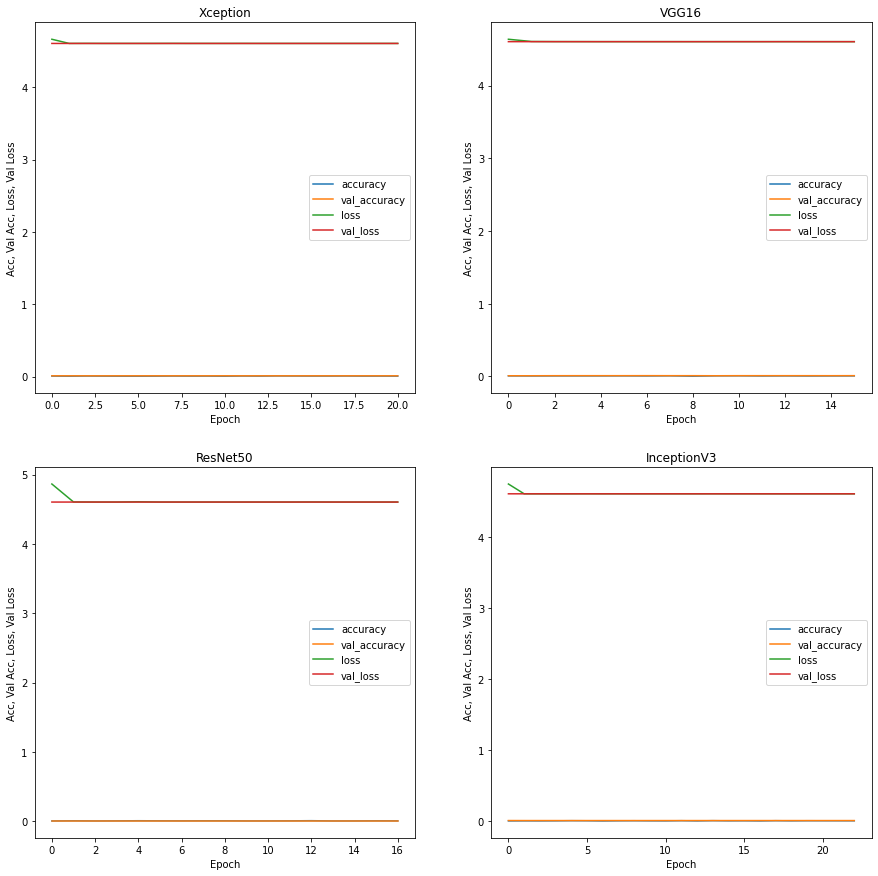

In [7]:
fig, axs = plt.subplots(2, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
axs[0, 0].plot(history_Xception.history['accuracy'], label = "accuracy")
axs[0, 0].plot(history_Xception.history['val_accuracy'], label = "val_accuracy")
axs[0, 0].plot(history_Xception.history['loss'], label = "loss")
axs[0, 0].plot(history_Xception.history['val_loss'], label = "val_loss")
axs[0, 0].legend()
axs[0, 0].set_title('Xception')
axs[0, 1].plot(history_VGG16.history['accuracy'], label = "accuracy")
axs[0, 1].plot(history_VGG16.history['val_accuracy'], label = "val_accuracy")
axs[0, 1].plot(history_VGG16.history['loss'], label = "loss")
axs[0, 1].plot(history_VGG16.history['val_loss'], label = "val_loss")
axs[0, 1].legend()
axs[0, 1].set_title('VGG16')
axs[1, 0].plot(history_ResNet50.history['accuracy'], label = "accuracy")
axs[1, 0].plot(history_ResNet50.history['val_accuracy'], label = "val_accuracy")
axs[1, 0].plot(history_ResNet50.history['loss'], label = "loss")
axs[1, 0].plot(history_ResNet50.history['val_loss'], label = "val_loss")
axs[1, 0].legend()
axs[1, 0].set_title('ResNet50')
axs[1, 1].plot(history_InceptionV3.history['accuracy'], label = "accuracy")
axs[1, 1].plot(history_InceptionV3.history['val_accuracy'], label = "val_accuracy")
axs[1, 1].plot(history_InceptionV3.history['loss'], label = "loss")
axs[1, 1].plot(history_InceptionV3.history['val_loss'], label = "val_loss")
axs[1, 1].legend()
axs[1, 1].set_title('InceptionV3')

axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Acc, Val Acc, Loss, Val Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Acc, Val Acc, Loss, Val Loss')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Acc, Val Acc, Loss, Val Loss')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Acc, Val Acc, Loss, Val Loss')

plt.show()

In [8]:
def get_parameters(model):
    model = globals()[model]
    trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    totalParams = trainableParams + nonTrainableParams
 
    return trainableParams, nonTrainableParams, totalParams

In [9]:
summary = pd.DataFrame(columns = ["Model",
                                  "Trainable parameters",
                                  "Non Trainable parameters",
                                  "Total Parameters",
                                  "Val loss",
                                  "Val accuracy"])
for model in list_of_models:
    trainableParams, nonTrainableParams, totalParams = get_parameters(model)
    eval = model.replace("model", "evaluation")
    data = {"Model":[model],
            "Trainable parameters": [trainableParams],
            "Non Trainable parameters": [nonTrainableParams],
            "Total Parameters": [totalParams],
            "Val loss": [round(globals()[eval][0],3)],            
            "Val accuracy": [round(globals()[eval][1],3)]
           }
    temp_df = pd.DataFrame(data)
    summary = pd.concat([summary, temp_df])
summary.set_index("Model")

,Trainable parameters,Non Trainable parameters,Total Parameters,Val loss,Val accuracy
Model,,,,,
model_Xception,40980300,20861480,61841780,4.605,0.01
model_VGG16,5037900,14714688,19752588,4.605,0.01
model_ResNet50,20090700,23587712,43678412,4.605,0.01
model_InceptionV3,26234700,21802784,48037484,4.605,0.01


## Conclusion 

Transfer Learning applications with weights learned on imagenet are not suitable for Aircraft Recognition problem. Validation Accuracy is low (1%). Full Model will be learned.